In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

## Credit Card Fraud

Using this credit card fraud dataset develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [2]:
data = pd.read_csv('C:\\Users\\david\Desktop\\thinkful datasets\\creditcard.csv')

data = data.drop(['Time'], 1)

In [3]:
data.shape

(284807, 30)

In [4]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,...,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,1.089,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,-0.535,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,-0.093,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,0.454,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


## Notes on Data

The data contains about 285k rows of data and 31 columns. Columns V1- V28 are different PCA transformations performed by the Kaggle user. The sensitivity of the data doesn't allow the original features to be known. The prediction model will utilize columns V1 through V28 and amount to predict credit card fraud.

The "Class" column  classifies if credit card fraud occured. The Describe method showed that fraud occured 0.173% of the time. This makes the dataset highly imbalanced. 

### Sub-sampling the data

In [5]:
print("There are {} instances of fraud in the dataset of {} rows".format(data.Class.sum(), data.shape[0]))

There are 492 instances of fraud in the dataset of 284807 rows


We are going to sub-sample the data so the non-fraud cases are equal to the cases of fraud.

In [6]:
# of instances of fraud 
fraud_data = data.loc[data['Class'] == 1]
fraud_index = np.array(data[data.Class == 1].index)

#instances of nonfraud
nonfraud_index = data.loc[data['Class'] == 0][:492]

In [7]:
normal_distributed_df = pd.concat([fraud_data, nonfraud_index])

# Randomizing the rows
equal_data = normal_distributed_df.sample(frac=1, random_state=42)

equal_data.head(8)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
121,-0.427,0.746,1.762,-0.165,0.058,-0.213,0.647,0.073,-0.292,0.065,...,-0.202,-0.432,0.013,0.162,-0.401,0.047,0.103,-0.117,9.120,0
248296,-0.614,3.699,-5.535,5.620,1.649,-2.335,-0.907,0.706,-3.748,-4.231,...,0.319,-0.471,-0.076,-0.668,-0.643,0.071,0.488,0.292,0.000,1
239,1.171,0.475,0.012,1.264,0.116,-0.866,0.554,-0.276,-0.471,0.029,...,0.070,0.279,-0.097,0.426,0.745,-0.275,0.008,0.015,20.000,0
239501,-6.683,-2.714,-5.775,1.450,-0.662,-1.149,0.850,0.433,-1.316,-2.796,...,0.221,1.187,0.336,0.216,0.803,0.044,-0.055,0.082,237.260,1
143336,-6.713,3.921,-9.747,5.148,-5.152,-2.099,-5.938,3.579,-4.685,-8.538,...,0.954,-0.451,0.127,-0.339,0.394,1.075,1.650,-0.395,252.920,1
90,0.921,-0.162,-0.094,0.474,-0.021,-0.398,0.483,-0.117,-0.578,-0.019,...,-0.209,-0.930,0.029,0.033,0.155,0.133,-0.074,0.022,149.900,0
215,1.211,0.008,0.951,1.138,-0.495,0.301,-0.518,0.095,0.818,-0.226,...,-0.107,-0.057,-0.119,-0.421,0.556,-0.360,0.077,0.032,9.990,0
150662,-5.839,7.152,-12.817,7.031,-9.651,-2.938,-11.543,4.844,-3.494,-13.321,...,2.462,1.055,0.530,0.473,-0.276,0.282,0.105,0.254,316.060,1


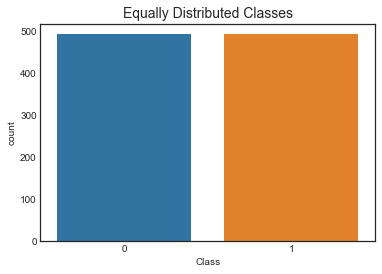

In [8]:
sns.countplot('Class', data=equal_data)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [9]:
equal_data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,984.000,984.000,984.000,984.000,984.000,984.000,984.000,984.000,984.000,984.000,...,984.000,984.000,984.000,984.000,984.000,984.000,984.000,984.000,984.000,984.000
mean,-2.467,1.905,-3.084,2.457,-1.562,-0.573,-2.731,0.261,-1.301,-2.805,...,0.355,-0.044,-0.037,-0.047,0.088,0.026,0.096,0.028,96.225,0.500
std,5.407,3.596,6.436,3.043,4.203,1.804,5.863,4.850,2.267,4.549,...,2.787,1.145,1.149,0.587,0.640,0.468,1.004,0.443,240.142,0.500
min,-30.552,-12.114,-31.104,-4.516,-22.106,-6.406,-43.557,-41.044,-13.434,-24.588,...,-22.798,-8.887,-19.254,-2.028,-4.782,-1.244,-7.263,-2.734,0.000,0.000
25%,-2.788,0.085,-5.085,0.346,-1.693,-1.443,-3.061,-0.171,-2.222,-4.572,...,-0.174,-0.534,-0.226,-0.415,-0.217,-0.297,-0.039,-0.050,1.790,0.000
50%,-0.781,0.955,-0.309,1.383,-0.390,-0.510,-0.433,0.153,-0.585,-0.594,...,0.093,-0.029,-0.051,0.028,0.127,-0.016,0.065,0.037,15.910,0.500
75%,0.870,2.727,0.934,4.175,0.427,0.233,0.305,0.808,0.114,-0.000,...,0.714,0.440,0.143,0.393,0.456,0.309,0.455,0.218,93.238,1.000
max,2.132,22.058,3.773,12.115,11.095,6.474,5.803,20.007,5.437,8.737,...,27.203,8.362,5.466,1.215,2.208,3.066,3.052,1.779,3828.040,1.000


It is now evident by the graph and the mean of 0.50 that we have created a new set of data where there are half the instances of fraud and  nonfraud.

Resources

[Data Imbalance help](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)


##  Performing a Logistic Regression

In [10]:
# Undersampling before cross validating (prone to overfit)
X = equal_data.drop('Class', axis=1)
y = equal_data['Class']

In [11]:
from sklearn.model_selection import train_test_split
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C=1e5)

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\n Accuracy by Fraud cases')
print(pd.crosstab(pred_y_sklearn, y))

print('\nPercentage accuracy\n{:.2f}%'.format(100*(lr.score(X, y))))

Coefficients
[[ 2.46980916e-01 -4.89364773e-02 -8.42248296e-01  8.30613766e-01
   1.16665591e-01 -7.83495484e-01  1.20807559e-01 -7.55689796e-01
   2.42048608e-01 -1.03048905e+00  3.46359335e-01 -2.04328752e+00
   4.88961235e-01  4.30315423e-01 -9.18273841e-01 -1.18950592e-01
   5.24890338e-01  7.83635274e-01 -5.33686738e-02 -9.49922696e-01
  -5.28504798e-02  1.47103834e+00  3.52618668e-01 -6.87100263e-01
  -9.75796841e-01  2.79707560e-01 -1.31267079e+00  6.74739618e-02
   2.02798279e-03]]
[-2.24134401]

 Accuracy by Fraud cases
Class    0    1
row_0          
0      485   24
1        7  468

Percentage accuracy
96.85%


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr, X, y, cv=5)

array([0.96969697, 0.95454545, 0.94897959, 0.95408163, 0.92857143])

In [ ]:
#TRY RANDOM FOREST